In [1]:
import torchvision
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np
import torch

# loading all packages here to start
from uni import get_encoder
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe
from uni.downstream.eval_patch_features.fewshot import eval_knn, eval_fewshot
from uni.downstream.eval_patch_features.protonet import ProtoNet, prototype_topk_vote
from uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics
from uni.downstream.utils import concat_images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = warnings, 2 = errors, 3 = fatal errors onlyimport os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')
os.environ['PATH'] = '/usr/local/cuda/bin:' + os.environ.get('PATH', '')

In [ ]:
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download

# login("")  # login with your User Access Token, found at https://huggingface.co/settings/tokens

local_dir = "../../assets/ckpts/vit_large_patch16_224.dinov2.uni_mass100k/"
os.makedirs(local_dir, exist_ok=True)  # create directory if it does not exist
# hf_hub_download("MahmoodLab/UNI", filename="pytorch_model.bin", local_dir=local_dir, force_download=True)
model = timm.create_model(
    "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu", weights_only=False), strict=True)
model.eval()

torch.cuda.empty_cache()  # Clear CUDA cache

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
transform

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)

In [ ]:
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader

# get path to BCSS data
dataroot = '../data/_bcss224/'

# create some image folder datasets for train/test and their data laoders
dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'train_0'), transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

# extract patch features from the train and test datasets (returns dictionary of embeddings and labels)
allfeatures = extract_patch_features_from_dataloader(model, dataloader)

# convert these to torch
allfeats = torch.Tensor(allfeatures['embeddings'])
alllabels = torch.Tensor(allfeatures['labels']).type(torch.long)

In [ ]:
# import pickle

# with open('../bcss_all_stainnorm.pkl', 'rb') as f:
#     bcss_df = pickle.load(f)

# bcss_df.head()

FileName  Major_labs        Tissue SiteID PatientID  \
0      patch_1           3  Inflammation     A2      A1G6   
1     patch_10           3  Inflammation     A2      A1G6   
2    patch_100           2        Stroma     A2      A0D0   
3   patch_1000           1         Tumor     AO      A0J2   
4  patch_10000           1         Tumor     BH      A0BL   

                         Lab_ratio  \
0  [0.163, 0.041, 0.795, 0.0, 0.0]   
1  [0.0, 0.351, 0.461, 0.0, 0.188]   
2    [0.0, 0.995, 0.005, 0.0, 0.0]   
3        [1.0, 0.0, 0.0, 0.0, 0.0]   
4   [0.471, 0.06, 0.0, 0.469, 0.0]   

                                           Hoptimus0  \
0  [0.2292124480009079, -0.020517492666840553, 0....   
1  [0.991219699382782, 0.03436296805739403, -0.29...   
2  [1.7162190675735474, 0.09933885931968689, -1.0...   
3  [0.6515170931816101, -0.5802224278450012, 1.18...   
4  [-0.0908508375287056, 0.5941020846366882, 0.14...   

                                   Hoptimus0_macenko  \
0  [0.08858220279216766, -0.015413234010338783, 0...   
1  [-0.022105885669589043, 0.12716807425022125, -...   
2  [0.9301583170890808, -0.18672248721122742, -1....   
3  [1.0321440696716309, -0.15893177688121796, 0.2...   
4  [0.30840304493904114, 0.5642123818397522, -0.2...   

                                  Hoptimus0_reinhard  \
0  [-0.3771764636039734, 0.1544204205274582, 0.31...   
1  [0.6843776702880859, 0.21336789429187775, -0.2...   
2  [-0.1379687637090683, 0.13495603203773499, -0....   
3  [0.49902650713920593, 0.07970137149095535, 1.0...   
4  [0.461221843957901, 0.48682689666748047, 0.194...   

                                                 UNI  ...  \
0  [0.23469898104667664, -1.9685664176940918, 0.7...  ...   
1  [0.7079142928123474, 1.3381421566009521, 1.462...  ...   
2  [1.9079161882400513, -2.4276857376098633, 1.07...  ...   
3  [-0.9357345700263977, 1.2807142734527588, 0.18...  ...   
4  [-0.3326460123062134, -1.321590781211853, -0.6...  ...   

                                    Virchow_reinhard  \
0  [0.625639796257019, -0.18093863129615784, 0.78...   
1  [0.4544388949871063, 0.5607439875602722, 0.960...   
2  [0.22235669195652008, -0.2943328022956848, 0.7...   
3  [0.5261357426643372, -0.3009600341320038, 0.70...   
4  [-0.07231058180332184, -1.199945092201233, 0.4...   

                                        ProvGigaPath  \
0  [0.07623041421175003, 0.4988909959793091, 1.16...   
1  [-0.9469607472419739, 0.5121889114379883, 0.76...   
2  [-0.413615882396698, -0.2432783991098404, -0.7...   
3  [-0.7987277507781982, -0.19164766371250153, -0...   
4  [-1.755966305732727, -0.47812196612358093, 0.7...   

                                ProvGigaPath_macenko  \
0  [0.7821192741394043, 0.12322071194648743, 0.48...   
1  [0.5912855863571167, 0.5418379902839661, 0.318...   
2  [-0.5954267382621765, 0.37531909346580505, -0....   
3  [-0.04383939877152443, -1.292541742324829, 1.0...   
4  [-0.7524905800819397, -0.6959168910980225, -0....   

                               ProvGigaPath_reinhard  \
0  [0.9816988706588745, -0.03928075358271599, -0....   
1  [-0.2987508475780487, -0.46214842796325684, -0...   
2  [0.044837091118097305, 0.1402568370103836, -0....   
3  [-0.17010925710201263, -1.2471312284469604, -0...   
4  [-0.07590875774621964, 0.22255489230155945, -0...   

                                    phikon2_reinhard  \
0  [-0.47941145300865173, 0.09473497420549393, -0...   
1  [-0.08226145803928375, 0.18629413843154907, -0...   
2  [0.06863473355770111, -0.28612619638442993, -0...   
3  [0.3891439735889435, 0.09636679291725159, -0.2...   
4  [-0.017869355157017708, -0.24299752712249756, ...   

                                             phikon2  \
0  [0.08502257615327835, -0.04549192264676094, -0...   
1  [-0.20628002285957336, -0.1507812738418579, -0...   
2  [-0.07253327965736389, -0.05763297900557518, -...   
3  [-0.12850019335746765, 0.19594421982765198, 0....   
4  [-0.03174116089940071, -0.0046435692347586155,...   

          

# UNI-2h

In [11]:
import umap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Retrieve the UNI2h embeddings from the DataFrame
UNI2h = torch.tensor(np.array(bcss_df['UNI2h_macenko'].values.tolist(), dtype=np.float32)).to(device)   # UNI2h embeddings

# Create mappings for SiteID and PatientID to indices
map_site_id = {site_id: i for i, site_id in enumerate(bcss_df['SiteID'].unique())}
map_patient_id = {patient_id: i for i, patient_id in enumerate(bcss_df['PatientID'].unique())}

major_labels = torch.tensor(bcss_df['Major_labs'].values, dtype=torch.float32).to(device)
site_ids = torch.tensor(bcss_df['SiteID'].map(map_site_id).values, dtype=torch.float32).to(device)
patient_ids = torch.tensor(bcss_df['PatientID'].map(map_patient_id).values, dtype=torch.float32).to(device)

# Convert tensors to numpy arrays for further processing
UNI2h_cpu = UNI2h.cpu().detach().numpy()
major_labels_cpu = major_labels.cpu().detach().numpy()
site_ids_cpu = site_ids.cpu().detach().numpy()
patient_ids_cpu = patient_ids.cpu().detach().numpy()

# Split the data into train and test sets with equal proportions between labels in site_ids
train_indices, test_indices = train_test_split(
    np.arange(len(site_ids_cpu)), 
    test_size=0.2, 
    stratify=site_ids_cpu
)

# Create train and test sets
UNI2h_train = UNI2h[train_indices]
UNI2h_test = UNI2h[test_indices]

### Site Tracking performance of UNI-2h features  

Linear Probe Evaluation: Train shape torch.Size([11969, 1536])
Linear Probe Evaluation: Test shape torch.Size([2993, 1536])
Linear Probe Evaluation (Train Time): Best cost = 307.200
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([11969, 1536])
(Before Training) Loss: 2.996
(After Training) Loss: 0.044
Linear Probe Evaluation (Test Time): Test Shape torch.Size([2993, 1536])
Linear Probe Evaluation: Time taken 0.94


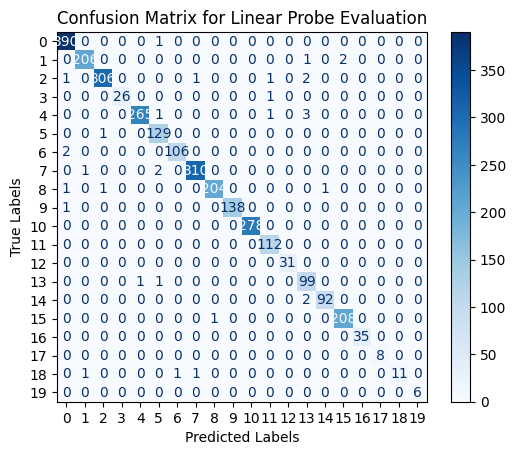

Test lin_acc: 0.989
Test lin_bacc: 0.980
Test lin_kappa: 0.983
Test lin_weighted_f1: 0.989
Test lin_auroc: 1.000


In [ ]:
linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = UNI2h_train,
    train_labels = site_ids_train,
    valid_feats = None ,
    valid_labels = None,
    test_feats = UNI2h_test,
    test_labels = site_ids_test,
    max_iter = 1000,
    verbose= True,
)

pred_labels = linprobe_dump['preds_all']
true_labels = site_ids_test

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.cpu(), pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Linear Probe Evaluation")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print_metrics(linprobe_eval_metrics)

### Tissue Classification performance of UNI-2h features  

Linear Probe Evaluation: Train shape torch.Size([11969, 1536])
Linear Probe Evaluation: Test shape torch.Size([2993, 1536])
Linear Probe Evaluation (Train Time): Best cost = 76.800
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([11969, 1536])
(Before Training) Loss: 1.609
(After Training) Loss: 0.231
Linear Probe Evaluation (Test Time): Test Shape torch.Size([2993, 1536])
Linear Probe Evaluation: Time taken 0.94


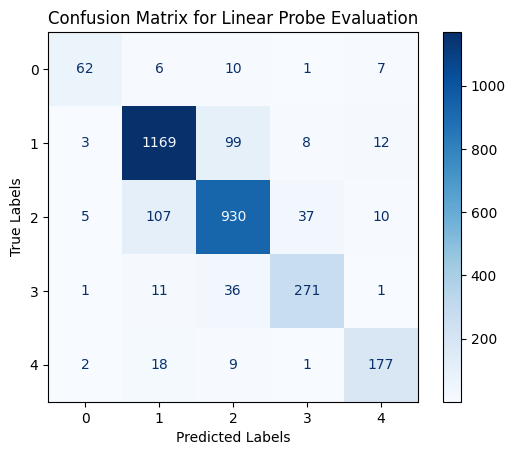

Test lin_acc: 0.872
Test lin_bacc: 0.836
Test lin_kappa: 0.820
Test lin_weighted_f1: 0.871
Test lin_auroc: 0.980


In [ ]:
linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = UNI2h[train_indices],
    train_labels = major_labels[train_indices].type(torch.long),
    valid_feats = None ,
    valid_labels = None,
    test_feats = UNI2h[test_indices],
    test_labels = major_labels[test_indices].type(torch.long),
    max_iter = 1000,
    verbose= True,
)

pred_labels = linprobe_dump['preds_all']
true_labels = major_labels[test_indices]

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.cpu(), pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Linear Probe Evaluation")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print_metrics(linprobe_eval_metrics)

## fmMAP feature generating

In [15]:
import umap
import matplotlib.pyplot as plt

# Apply fmMAP
n_features_uni2h = UNI2h.shape[1]  # Number of features in the UNI2h embeddings

uni2h_reducer = umap.UMAP(n_components=n_features_uni2h, n_neighbors=15, min_dist=0.1)
uni2h_embedding = uni2h_reducer.fit_transform(UNI2h_cpu, major_labels_cpu)

um_tensor = torch.tensor(uni2h_embedding, dtype=torch.float32).to(device)
um_tensor_train = um_tensor[train_indices]
um_tensor_test = um_tensor[test_indices]

site_ids_train = site_ids[train_indices].type(torch.long)
site_ids_test = site_ids[test_indices].type(torch.long)


### Site Tracking performance of fmMAP embeddings

Linear Probe Evaluation: Train shape torch.Size([11969, 1536])
Linear Probe Evaluation: Test shape torch.Size([2993, 1536])
Linear Probe Evaluation (Train Time): Best cost = 307.200
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([11969, 1536])
(Before Training) Loss: 2.996
(After Training) Loss: 0.600
Linear Probe Evaluation (Test Time): Test Shape torch.Size([2993, 1536])
Linear Probe Evaluation: Time taken 5.93


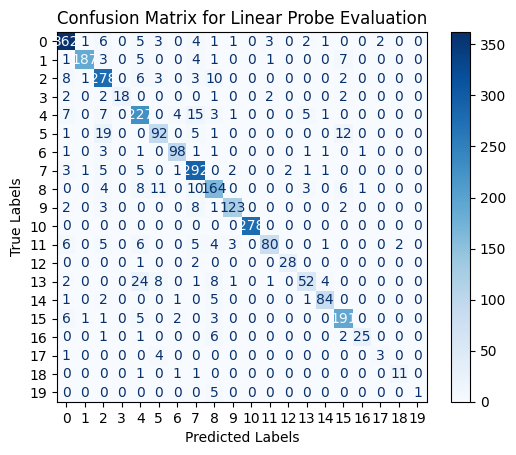

Test lin_acc: 0.867
Test lin_bacc: 0.771
Test lin_kappa: 0.855
Test lin_weighted_f1: 0.864
Test lin_auroc: 0.986


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe
import matplotlib.pyplot as plt

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = um_tensor_train,
    train_labels = site_ids_train,
    valid_feats = None ,
    valid_labels = None,
    test_feats = um_tensor_test,
    test_labels = site_ids_test,
    max_iter = 1000,
    verbose= True,
)

pred_labels = linprobe_dump['preds_all']
true_labels = site_ids_test

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.cpu(), pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Linear Probe Evaluation")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print_metrics(linprobe_eval_metrics)

### Tissue Classification performance of UNI-2h features  

Linear Probe Evaluation: Train shape torch.Size([11969, 1536])
Linear Probe Evaluation: Test shape torch.Size([2993, 1536])
Linear Probe Evaluation (Train Time): Best cost = 76.800
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([11969, 1536])
(Before Training) Loss: 1.609
(After Training) Loss: 0.077
Linear Probe Evaluation (Test Time): Test Shape torch.Size([2993, 1536])
Linear Probe Evaluation: Time taken 0.94


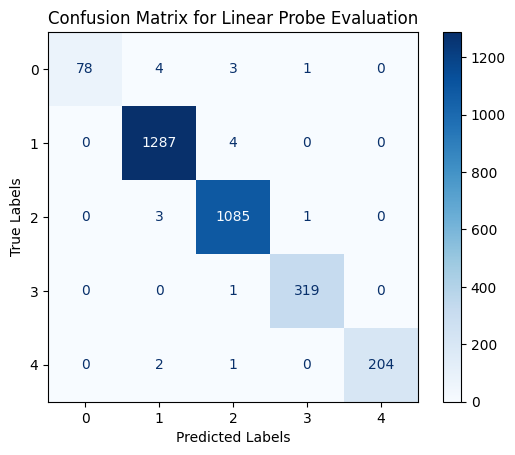

Test lin_acc: 0.993
Test lin_bacc: 0.977
Test lin_kappa: 0.989
Test lin_weighted_f1: 0.993
Test lin_auroc: 0.991


In [19]:
linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = um_tensor[train_indices],
    train_labels = major_labels[train_indices].type(torch.long),
    valid_feats = None ,
    valid_labels = None,
    test_feats = um_tensor[test_indices],
    test_labels = major_labels[test_indices].type(torch.long),
    max_iter = 1000,
    verbose= True,
)

pred_labels = linprobe_dump['preds_all']
true_labels = major_labels[test_indices]

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.cpu(), pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for Linear Probe Evaluation")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print_metrics(linprobe_eval_metrics)